In [1]:
import pandas as pd
from lib.utils import *



In [2]:
train = pd.read_csv('train.csv')
print("Training Set:"% train.columns, train.shape)
test = pd.read_csv('test.csv')
print("Test Set:"% test.columns, test.shape)

print('Train_Set -----')
print(train.isnull().sum())
print('Test_set -----')
print(test.isnull().sum())
train.head()


Training Set: (31962, 3)
Test Set: (17197, 2)
Train_Set -----
id       0
label    0
tweet    0
dtype: int64
Test_set -----
id       0
tweet    0
dtype: int64


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [3]:
import re
from sklearn.utils import resample

def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df
test_clean = clean_text(test, "tweet")
train_clean = clean_text(train, "tweet")

train_majority = train_clean[train_clean.label==0]
train_minority = train_clean[train_clean.label==1]
train_minority_upsampled = resample(train_minority, 
                                 replace=True,    
                                 n_samples=len(train_majority),   
                                 random_state=123)
train_upsampled = pd.concat([train_minority_upsampled, train_majority])
train_upsampled['label'].value_counts()

1    29720
0    29720
Name: label, dtype: int64

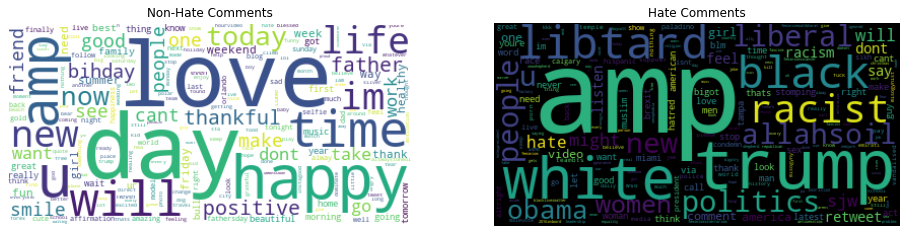

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(train_clean['tweet'][train.label == 0])
text_neg = " ".join(train_clean['tweet'][train.label == 1])
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

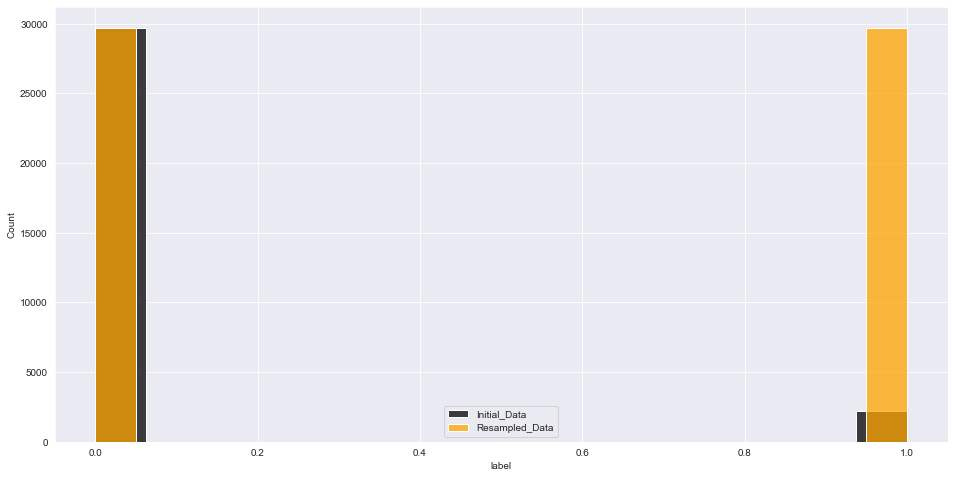

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
sns.set_style('darkgrid')
sns.histplot(data = train['label'], color='black', legend=True)
sns.histplot(data = train_upsampled['label'], color = 'orange', legend=True)
plt.legend(['Initial_Data', 'Resampled_Data'])
plt.show()

--------------After Upsampling the Minority Class---------------


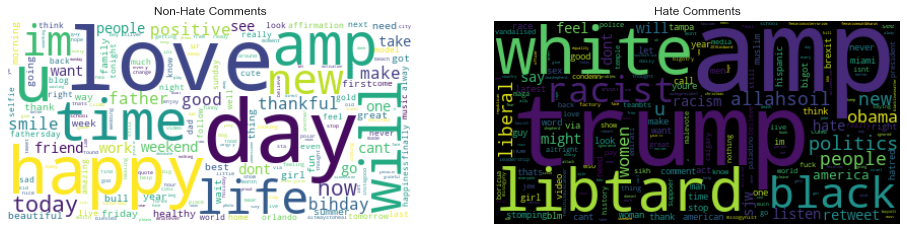

In [6]:
from wordcloud import WordCloud

print('--------------After Upsampling the Minority Class---------------')

fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(train_upsampled['tweet'][train.label == 0])
text_neg = " ".join(train_upsampled['tweet'][train.label == 1])
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

In [7]:
import xgboost as xgb
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score


pipeline_xgb = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf',  TfidfTransformer()),
    ('nb', xgb.XGBClassifier(use_label =False)),])

x_train, x_test, y_train, y_test = train_test_split(train_upsampled['tweet'],
                                                    train_upsampled['label'],random_state = 0)



In [8]:
X,y=scaler_transform(train_upsampled['tweet'])
from sklearn.model_selection import train_test_split
ac=[]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [9]:
from sklearn.svm import SVC  #svm model
model=SVC(gamma='auto')
model.fit(X_train, y_train)  #training the svm model
y_pred = model.predict(X_test) #testing the svm
ac.append(accuracy_score(y_pred,y_test,sample_weight=1)*100)

In [10]:

from keras.models import Sequential #cnn model
from keras.layers import Dense
model = Sequential()
model.add(Dense(11,activation='relu',input_dim=4))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam')
model.fit(X_train,y_train,epochs=3)
ac.append(accuracy_score(model,y_test,sample_weight=0.2)*100)

Epoch 1/3
4/4 [==============================] - 1s 0s/step - loss: 2.9153
Epoch 2/3
4/4 [==============================] - 0s 0s/step - loss: 2.8054
Epoch 3/3
4/4 [==============================] - 0s 0s/step - loss: 2.7012


In [11]:
import pickle
f=open('model.pkl','rb')
m=pickle.load(f)


In [ ]:
def predict(inp):
    inp = pd.Series(inp)
    yhat = ((np.ravel(m.predict(inp)).tolist()))
    if yhat[-1] == 1:
        print('Conc : Hate_Comment_Detected')
    if yhat[-1] == 0:
        print('Conc: Not_a_hate_comment')
    

inp = []
num_of_comments = int(input("enter num of comments you want to check: "))
for i in range(num_of_comments):
    comment = input(f"enter comment {i+1}: ")
    inp.append(comment)
print('--'*30)
print('  '*30)
print('  '*30)
print('  '*30)
for i in inp:
    print('Entered_Comment: ', i)
    predict(i)
    print('--'*30)


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib as plt

plt.style.use('ggplot')
x=['SVM','CNN']
 
ax=sns.barplot(x,ac)
ax.set_title('Accuracy comparison')
ax.set_ylabel('Accuracy')
#ax.yaxis.set_major_locator(ticker.LinearLocator())
print("the accuracy of {} is {} and {} is {}".format(x[0],ac[0],x[1],ac[1]))
ax.set_ylim(50,100)
import pandas as pd
data={'Agorithms':x,
     "accuracy":ac}
df=pd.DataFrame(data)
df.head()